# Predicting Churn

In [85]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

np.random.seed(123)
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=3)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

## Perguntas:


1. Qual a taxa de Churn atual da empresa?
2. Como a taxa de Churn varia por mês?
3. Qual a Performance do modelo em classificar os clientes como churns?
4. Qual o Faturamento da empresa, se ela impedir que os clientes de entrar em Churn através do seu modelo?
5. Qual o valor de um cupom de desconto você daria para o cliente, a fim de evitar churn? E qual o custo total desse incentivo para a empresa?

### Dataset

**RowNumber**: corresponds to the record (row) number and has no effect on the output.  
**CustomerId**: contains random values and has no effect on customer leaving the bank.  
**Surname**: the surname of a customer has no impact on their decision to leave the bank.  
**CreditScore**: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.  
**Geography**: a customer’s location can affect their decision to leave the bank.  
**Gender**: it’s interesting to explore whether gender plays a role in a customer leaving the bank.  
**Age**: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.  
**Tenure**: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.  
**Balance**: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.  
**NumOfProducts**: refers to the number of products that a customer has purchased through the bank.  
**HasCrCard**: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.  
**IsActiveMember**: active customers are less likely to leave the bank.  
**EstimatedSalary**: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.  
**Exited**: whether or not the customer left the bank. (0=No,1=Yes)

In [2]:
df = pd.read_csv('data/churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Cleaning

I will drop ['RowNumber', 'CustomerId', 'Surname'], since they are useless for prediction.

In [3]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


I'll map 'Gender' to integers for ML reasons later.

In [4]:
print(df.Gender.unique())
df.Gender = df.Gender.map({'Male': 0,'Female': 1})
df.Gender

['Female' 'Male']


0       1
1       1
2       1
3       1
4       1
       ..
9995    0
9996    0
9997    1
9998    0
9999    1
Name: Gender, Length: 10000, dtype: int64

Similarly, 'Geography' can be one-hot-encoded since there are only 3 countries.

In [5]:
print(df.Geography.unique())
df = pd.concat([df, pd.get_dummies(df['Geography'], prefix='country_')],axis=1)
df['Country'] = df.Geography.map({'France': 0, 'Spain': 1, 'Germany': 2})

df.head()

['France' 'Spain' 'Germany']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country__France,country__Germany,country__Spain,Country
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,1,0,0,0
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0
3,699,France,1,39,1,0.00,2,0,0,93826.63,0,1,0,0,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1


## Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CreditScore       10000 non-null  int64  
 1   Geography         10000 non-null  object 
 2   Gender            10000 non-null  int64  
 3   Age               10000 non-null  int64  
 4   Tenure            10000 non-null  int64  
 5   Balance           10000 non-null  float64
 6   NumOfProducts     10000 non-null  int64  
 7   HasCrCard         10000 non-null  int64  
 8   IsActiveMember    10000 non-null  int64  
 9   EstimatedSalary   10000 non-null  float64
 10  Exited            10000 non-null  int64  
 11  country__France   10000 non-null  uint8  
 12  country__Germany  10000 non-null  uint8  
 13  country__Spain    10000 non-null  uint8  
 14  Country           10000 non-null  int64  
dtypes: float64(2), int64(9), object(1), uint8(3)
memory usage: 966.9+ KB


**No missing values!! =)**

In [7]:
df.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country__France,country__Germany,country__Spain,Country
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.454300,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700,0.749500
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698,0.830433
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,489.000000,0.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,0.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000,2.000000
90%,778.000000,1.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000,1.000000,1.000000,1.000000,2.000000
95%,812.000000,1.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000,1.000000,1.000000,1.000000,2.000000


In [8]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'country__France', 'country__Germany', 'country__Spain',
       'Country'],
      dtype='object')

In [75]:
def hargs(bins=np.arange(0, 2, 1), hstep='step', lwidth=3, c='r', label='Churn', normed=False):
    return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

In [78]:
def plot_vars(normed=False):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
    (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = ax

    mask = (df.Exited == 1)

    bins = np.arange(300, 900, 50)
    ax1.hist(df.CreditScore[mask], **hargs(bins=bins, normed=normed))       
    ax1.hist(df.CreditScore[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax1.set_xlabel('Credit Score')
    ax1.legend(loc='upper left')

    bins = np.arange(10, 110, 10)
    ax2.hist(df.Age[mask], **hargs(bins=bins, normed=normed))
    ax2.hist(df.Age[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax2.set_xlabel('Age')
    ax2.legend()

    bins = np.arange(0, 11, 1)
    ax3.hist(df.Tenure[mask], **hargs(bins=bins, normed=normed))
    ax3.hist(df.Tenure[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax3.set_xlabel('Tenure')
    ax3.legend(loc='upper left')

    bins = np.arange(0, 300_000, 20_000)
    ax4.hist(df.Balance[mask], **hargs(bins=bins, normed=normed))
    ax4.hist(df.Balance[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax4.set_xlabel('Balance')
    ax4.legend()

    bins = np.arange(-0.5, 3.5, 1)
    ax5.hist(df.Country[mask], **hargs(bins=bins, normed=normed))
    ax5.hist(df.Country[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax5.set_xlabel('Country')
    ax5.legend()

    bins = np.arange(.5, 5.5, 1)
    ax6.hist(df.NumOfProducts[mask], **hargs(bins=bins, normed=normed))
    ax6.hist(df.NumOfProducts[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax6.set_xlabel('#  of Products')
    ax6.legend()

    bins = np.arange(0, 200_000, 20_000)
    ax7.hist(df.EstimatedSalary[mask], **hargs(bins=bins, normed=normed))
    ax7.hist(df.EstimatedSalary[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax7.set_xlabel('Estimated Salary')
    ax7.legend(loc='best')

    bins = np.arange(0, 0.7, 0.05)
    ax8.hist(df.Tenure[mask] / df.Age[mask], **hargs(bins=bins, normed=normed))
    ax8.hist(df.Tenure[~mask] / df.Age[~mask], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax8.set_xlabel('Tenure/Age')
    ax8.legend()


    plt.show()

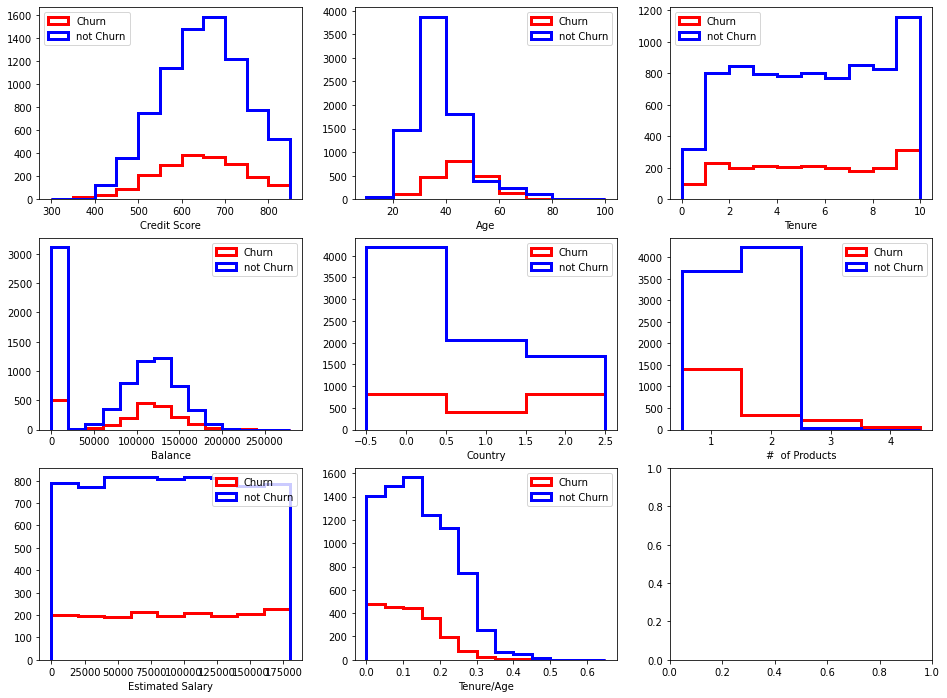

In [79]:
plot_vars(normed=False)

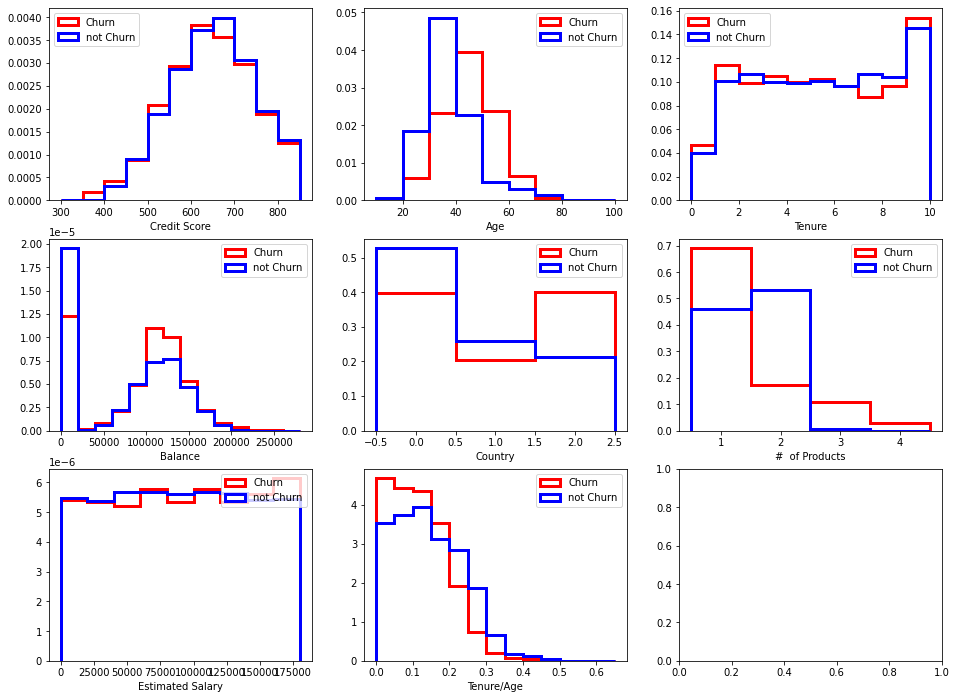

In [80]:
plot_vars(normed=True)

In [ ]:
attributes = ['Age', 'Balance', 'Tenure', 'NumOfProducts',
              'CreditScore', 'EstimatedSalary', 'Country']

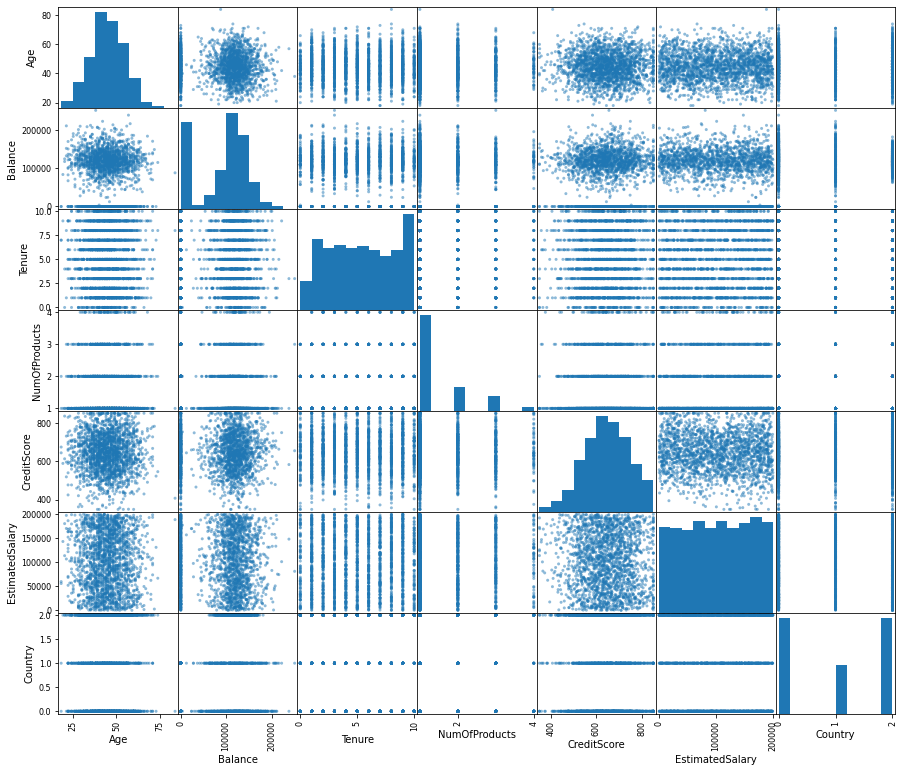

In [86]:
scatter_matrix(df[mask][attributes], figsize=(15, 13))
plt.show()

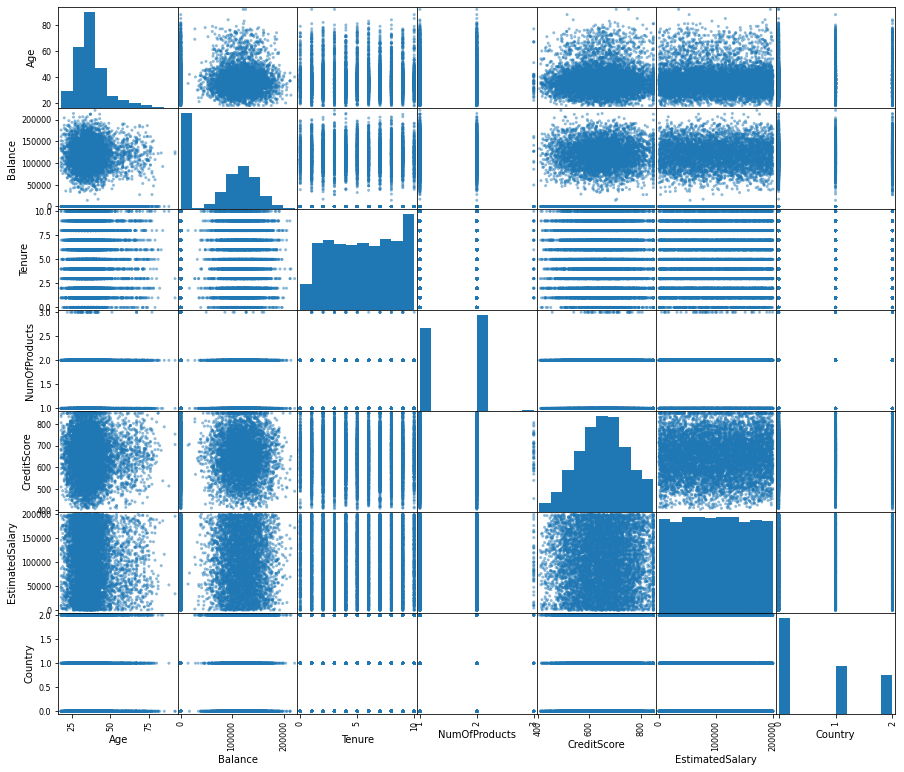

In [87]:
scatter_matrix(df[~mask][attributes], figsize=(15, 13))
plt.show()

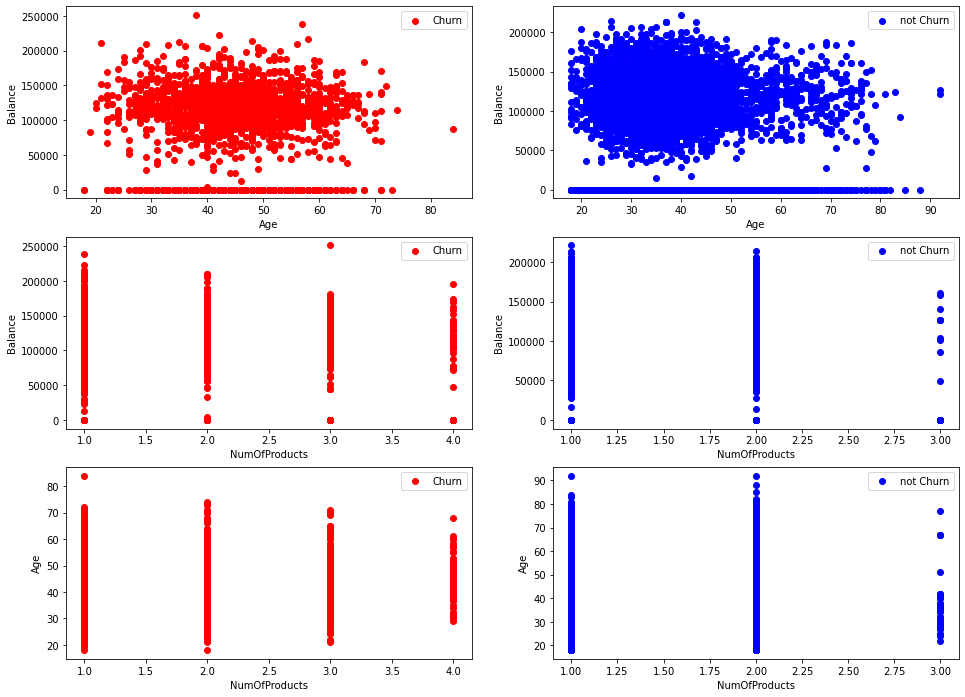

In [82]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4), (ax5, ax6) = ax

mask = (df.Exited == 1)

ax1.scatter(x=df.Age[mask], y=df.Balance[mask], label='Churn', color='r')  
ax1.set_xlabel('Age')
ax1.set_ylabel('Balance')
ax1.legend(loc='best')

ax2.scatter(x=df.Age[~mask], y=df.Balance[~mask], label='not Churn', color='b')
ax2.set_xlabel('Age')
ax2.set_ylabel('Balance')
ax2.legend(loc='best')

ax3.scatter(x=df.NumOfProducts[mask], y=df.Balance[mask], label='Churn', color='r')  
ax3.set_xlabel('NumOfProducts')
ax3.set_ylabel('Balance')
ax3.legend(loc='best')

ax4.scatter(x=df.NumOfProducts[~mask], y=df.Balance[~mask], label='not Churn', color='b')
ax4.set_xlabel('NumOfProducts')
ax4.set_ylabel('Balance')
ax4.legend(loc='best')

ax5.scatter(x=df.NumOfProducts[mask], y=df.Age[mask], label='Churn', color='r')  
ax5.set_xlabel('NumOfProducts')
ax5.set_ylabel('Age')
ax5.legend(loc='best')

ax6.scatter(x=df.NumOfProducts[~mask], y=df.Age[~mask], label='not Churn', color='b')
ax6.set_xlabel('NumOfProducts')
ax6.set_ylabel('Age')
ax6.legend(loc='best')

plt.show()

In [58]:
def print_prop(table):
    name = table.columns.name
    a0, b0 = table[0]
    a1, b1 = table[1]
    tot0, tot1 = a0 + b0, a1 + b1
    tot = tot0 + tot1
    print(f'Total of {name} = {tot}')
    print(f'Proportion of {name}==0: {100.*tot0/tot:.2f}%')
    print(f'Proportion of {name}==1: {100.*tot1/tot:.2f}%')
    print(f'Proportion of {name}==0 that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of {name}==1 that Churned: {100.*b1/tot1:.2f}%')
    
def print_prop3(table):
    name = table.columns.name
    a0, b0 = table['France']
    a1, b1 = table['Spain']
    a2, b2 = table['Germany']
    tot0, tot1, tot2 = a0 + b0, a1 + b1, a2 + b2
    tot = tot0 + tot1 + tot2
    print(f'Total of {name} = {tot}')
    print(f'Proportion of France: {100.*tot0/tot:.2f}%')
    print(f'Proportion of Spain: {100.*tot1/tot:.2f}%')
    print(f'Proportion of Germany: {100.*tot2/tot:.2f}%')
    print(f'Proportion of France that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of Spain that Churned: {100.*b1/tot1:.2f}%')
    print(f'Proportion of Germany that Churned: {100.*b2/tot2:.2f}%')    

In [59]:
table = df.groupby(['Exited', 'HasCrCard']).agg('count').Balance.unstack()
print_prop(table)
table

Total of HasCrCard = 10000
Proportion of HasCrCard==0: 29.45%
Proportion of HasCrCard==1: 70.55%
Proportion of HasCrCard==0 that Churned: 20.81%
Proportion of HasCrCard==1 that Churned: 20.18%


HasCrCard,0,1
Exited,,
0,2332,5631
1,613,1424


In [60]:
table = df.groupby(['Exited', 'Gender']).agg('count').Balance.unstack()
print_prop(table)
table

Total of Gender = 10000
Proportion of Gender==0: 54.57%
Proportion of Gender==1: 45.43%
Proportion of Gender==0 that Churned: 16.46%
Proportion of Gender==1 that Churned: 25.07%


Gender,0,1
Exited,,
0,4559,3404
1,898,1139


In [61]:
table = df.groupby(['Exited', 'IsActiveMember']).agg('count').Balance.unstack()
print_prop(table)
table

Total of IsActiveMember = 10000
Proportion of IsActiveMember==0: 48.49%
Proportion of IsActiveMember==1: 51.51%
Proportion of IsActiveMember==0 that Churned: 26.85%
Proportion of IsActiveMember==1 that Churned: 14.27%


IsActiveMember,0,1
Exited,,
0,3547,4416
1,1302,735


In [62]:
table = df.groupby(['Exited', 'Geography']).agg('count').Balance.unstack()
print_prop3(table)
table

Total of Geography = 10000
Proportion of France: 50.14%
Proportion of Spain: 24.77%
Proportion of Germany: 25.09%
Proportion of France that Churned: 16.15%
Proportion of Spain that Churned: 16.67%
Proportion of Germany that Churned: 32.44%


Geography,France,Germany,Spain
Exited,,,
0,4204,1695,2064
1,810,814,413


## Prepare for Models

In [88]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'country__France', 'country__Germany', 'country__Spain',
       'Country'],
      dtype='object')

In [94]:
y = df.Exited
X = df.copy()

In [96]:
X.drop(columns=['Geography', 'Country', 'Exited'], inplace=True)
assert len(X) == len(y)

# STOPED HERE

save for ML and start another notebook

# 1 - Qual a taxa de Churn atual da empresa?

In [15]:
total_churn = df.Exited.sum()
churn_ratio = total_churn / len(df)

print(f'Numero total de churns = {total_churn}')
print(f'Taxa de churn = {100.*churn_ratio:.2f}%')

Numero total de churns = 2037
Taxa de churn = 20.37%


# 2 - Como a taxa de Churn varia por mês?